In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
class Neuron(eqx.Module):
    weight: jax.Array
    bias: jax.Array
    activation: callable

    def __init__(self, in_features, activation=jax.nn.relu, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
            key, _ = jax.random.split(key)
        w_key, b_key = jax.random.split(key)
        self.weight = jax.random.normal(w_key, (in_features,))
        self.bias = jax.random.normal(b_key, ())

        self.activation = activation

    def __call__(self, x):
        return self.activation(jnp.dot(self.weight, x) + self.bias)
    
    def importance(self):
        return jnp.linalg.norm(self.weight)


In [ ]:
def identity(x):
    return x


In [ ]:
class CustomMLP(eqx.Module):
    layers: list

    def __init__(self, input_size, hidden_sizes, output_size, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        act_key = jax.random.split(keys[-1], 1)[0]
        activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
        layers = []
        in_features = input_size

        # Create hidden layers
        for i, out_features in enumerate(hidden_sizes):
            layer = [Neuron(in_features, activation_list[jax.random.choice(act_key, jnp.arange(len(activation_list)))], key=keys[i]) for _ in range(out_features)]
            layers.append(layer)
            in_features = out_features

        # Create output layer
        output_layer = [Neuron(in_features, activation=identity, key=keys[-1]) for _ in range(output_size)]
        layers.append(output_layer)

        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = jnp.array([neuron(x) for neuron in layer])
        return x[0]  # Since output layer is a single neuron

    def add_neuron(self, layer_index, activation=jax.nn.relu, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        in_features = self.layers[layer_index][0].weight.shape[0]
        new_neuron = Neuron(in_features, activation, key)
        self.layers[layer_index].append(new_neuron)

        # Adjust the next layer's weight matrix to include the new neuron
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                new_weight = jax.random.normal(key, (1,))
                updated_weights = jnp.append(next_neuron.weight, new_weight)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)

    def remove_neuron(self, layer_index, neuron_index):
        if len(self.layers[layer_index]) <= 1:
            raise ValueError("Cannot remove the last neuron in a layer")
        
        del self.layers[layer_index][neuron_index]
        
        # Adjust the next layer's weight matrix to remove the corresponding weight
        if layer_index + 1 < len(self.layers):
            for i, next_neuron in enumerate(self.layers[layer_index + 1]):
                updated_weights = jnp.delete(next_neuron.weight, neuron_index)
                self.layers[layer_index + 1][i] = eqx.tree_at(lambda n: n.weight, next_neuron, updated_weights)
    
    def get_shape(self):
        return [len(layer) for layer in self.layers]
    
    def least_important_neuron(self):
        all_importances = []
        layer_sizes = []
        for layer in self.layers:
            importances = [n.importance() for n in layer]
            all_importances.append(jnp.array(importances).flatten())  # Flatten the importances
            layer_sizes.append(len(layer))

        all_importances = jnp.concatenate(all_importances)
        sorted_indices = jnp.argsort(all_importances)

        # Locate the layer and neuron index
        cum_neurons = jnp.cumsum(jnp.array(layer_sizes))
        for min_importance_index in sorted_indices:
            layer_index = jnp.searchsorted(cum_neurons, min_importance_index, side="right")
            neuron_index = min_importance_index - (cum_neurons[layer_index - 1] if layer_index > 0 else 0)
            if neuron_index != len(self.layers[layer_index]) - 1:  # If the neuron is not the last one of its layer
                return layer_index, neuron_index
        
        raise ValueError("All neurons are the last ones of their layers")

    def most_important_layer(self):
        # Calculate the total importance of each layer
        layer_importances = [jnp.sum(jnp.array([n.importance() for n in layer])) for layer in self.layers[:-1]]
        most_important_layer_index = jnp.argmax(jnp.array(layer_importances))  # Convert to Jax array

        return most_important_layer_index


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))


In [ ]:

input_size = 3
hidden_sizes = [2, 3]  # Two hidden layers
output_size = 1

key = jax.random.PRNGKey(42)
mlp = CustomMLP(input_size, hidden_sizes, output_size, key)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)


In [ ]:
mlp.get_shape()

[2, 3, 1]

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
mlp = CustomMLP(input_size, hidden_sizes, output_size, key)

In [ ]:
activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
jax.random.choice(key, jnp.arange(len(activation_list)))

Array(2, dtype=int32)

In [ ]:
activation_list = [jax.nn.relu, jax.nn.sigmoid, jax.nn.tanh]
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
Loss_history = []
Node_history = []
Update_history = []
threshold = 1e-8

In [ ]:
len(mlp.layers[0])

2

If loss is greater than threshold,
    1. add neuron, run a little.
     if loss is worse, remove neuron.
     if loss is better, keep neuron.

If loss is less than threshold, stop.


In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:
        if len(Update_history) == 0 or Update_history[-1][2] > loss or Update_history[-1][3] == "removed":
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layer_idx = mlp.most_important_layer()
            mlp.add_neuron(layer_index=layer_idx, activation=activation, key=act_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer_idx))
            print(f"Added neuron to hidden layer {layer_idx+1} with activation {activation.__name__}")
            print(mlp.get_shape())
        
        elif Update_history[-1][2] < loss:
            # if last addition doesn't improve loss, remove the worst neuron

            layer_idx, neuron_idx = mlp.least_important_neuron()
            print(f"Removing neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            mlp.remove_neuron(layer_index=layer_idx, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer_idx))
            print(f"Rejecting last addition,\n Removed neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            print(mlp.get_shape())
        
    if loss < threshold:
        # if loss is below threshold, stop training
        print(f"Threshold reached, stopping training at epoch {epoch}")
        break
    


print("Final Prediction:", mlp(x))

Epoch 0, Prediction: -0.6204530596733093, Loss: 3.089740514755249
Epoch 1, Prediction: -0.4938748776912689, Loss: 2.625868320465088
Epoch 2, Prediction: -0.3771905303001404, Loss: 2.2316622734069824
Epoch 3, Prediction: -0.26962459087371826, Loss: 1.8966538906097412
Epoch 4, Prediction: -0.17046353220939636, Loss: 1.6119465827941895
Epoch 5, Prediction: -0.07904988527297974, Loss: 1.3699849843978882
Epoch 6, Prediction: 0.005222797393798828, Loss: 1.1643484830856323
Epoch 7, Prediction: 0.0829126164317131, Loss: 0.9895817041397095
Epoch 8, Prediction: 0.15453429520130157, Loss: 0.8410492539405823
Epoch 9, Prediction: 0.22056177258491516, Loss: 0.7148122787475586
Added neuron to hidden layer 2 with activation sigmoid
[2, 4, 1]
Epoch 10, Prediction: -0.6745746731758118, Loss: 3.4359378814697266
Epoch 11, Prediction: -0.5128397941589355, Loss: 2.8042001724243164
Epoch 12, Prediction: -0.36674320697784424, Loss: 2.288684129714966
Epoch 13, Prediction: -0.23476895689964294, Loss: 1.86798703

In [ ]:
Update_history

[(9, 6, Array(0.7148123, dtype=float32), 'sigmoid', Array(1, dtype=int32)),
 (19, 7, Array(0.5524005, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (29, 8, Array(0.2868073, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (39, 9, Array(0.0031635, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (49, 10, Array(0.00301508, dtype=float32), 'sigmoid', Array(1, dtype=int32)),
 (59, 11, Array(0.05076867, dtype=float32), 'removed', Array(0, dtype=int32)),
 (69, 10, Array(0.00397928, dtype=float32), 'relu', Array(1, dtype=int32)),
 (79, 11, Array(0.0065453, dtype=float32), 'removed', Array(1, dtype=int32)),
 (89, 10, Array(0.04594354, dtype=float32), 'relu', Array(1, dtype=int32)),
 (99, 11, Array(0.00285998, dtype=float32), 'relu', Array(1, dtype=int32)),
 (109, 12, Array(5.144709e-06, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (119, 13, Array(0.00034019, dtype=float32), 'removed', Array(1, dtype=int32)),
 (129,
  12,
  Array(3.7984051e-07, dtype=float32),
  'sigmoid',
  Array(1, dty

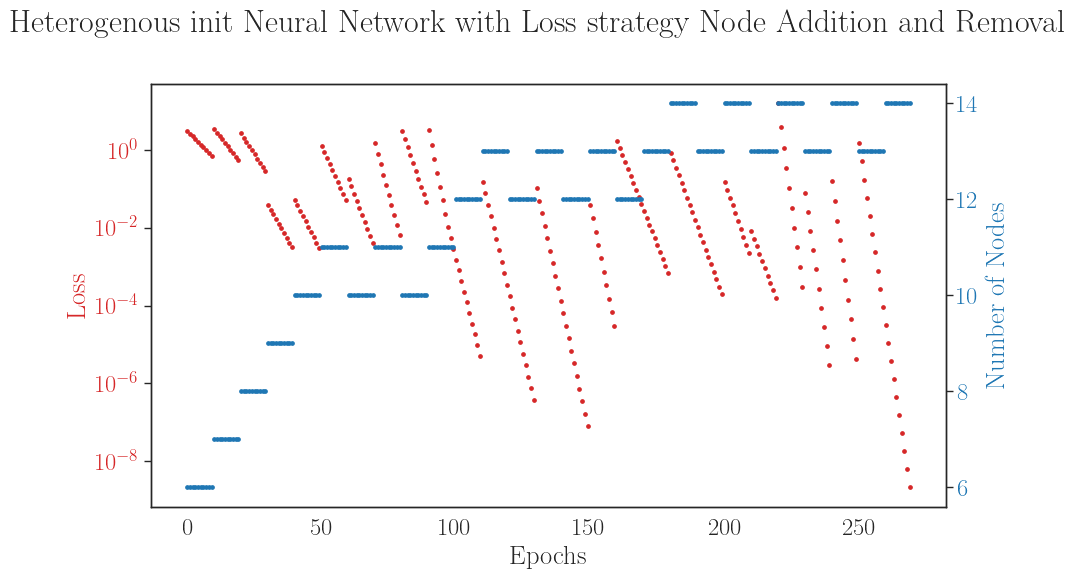

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Heterogenous init Neural Network with Loss+Weight strategy Node Addition and Removal")
fig.tight_layout()

epoch, n_neurons, loss, activation, layer
009, 06, 0.7148123, 'sigmoid', 1
019, 07, 0.33601144, 'tanh', 1
029, 08, 0.02160545, 'tanh', 0
039, 09, 0.00304363, 'tanh', 0
049, 10, 0.00020554, 'sigmoid', 0
059, 11, 0.00186709, 'removed', 0
069, 10, 0.00103108, 'relu', 0
079, 11, 0.00011032, 'tanh', 0
089, 12, 0.00050245, 'removed', 0
099, 11, 0.00033281, 'relu', 1
109, 12, 0.00083492, 'removed', 1
119, 11, 0.04249593, 'tanh', 0
129, 12, 0.00514497, 'sigmoid', 1
139, 13, 0.00092623, 'tanh', 1
149, 14, 0.00030042, 'relu', 0
159, 15, 0.00038551, 'removed', 0
169, 14, 0.00079688, 'relu', 1
179, 15, 1.1583303e-07, 'sigmoid',0
189, 16, 7.366907e-11, 'relu', 1
